In [1]:
from fredapi import Fred
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import plotly.express as px

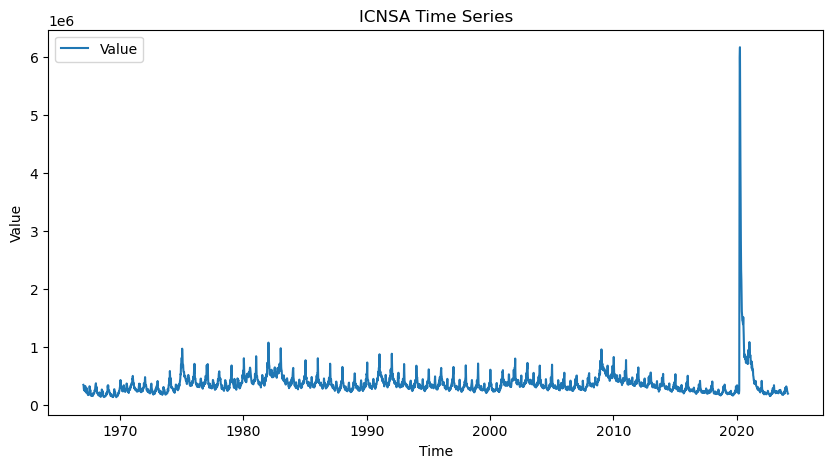

In [30]:

api_key = "53b538f58efe93c97a8626e8559a0372"
fred = Fred(api_key=api_key)

series_id = "ICNSA"
data = fred.get_series(series_id)

icnsa_df = data.to_frame().reset_index()
icnsa_df.columns = ['time', 'I_value']


# Plotting the time series using Matplotlib
plt.figure(figsize=(10, 5)) 
plt.plot(icnsa_df['time'], icnsa_df['I_value'], label='Value') 
plt.title(f"{series_id} Time Series")  
plt.xlabel('Time')
plt.ylabel('Value')  
plt.legend()  
plt.show()  


In [23]:
data

1967-01-07    346000.0
1967-01-14    334000.0
1967-01-21    277000.0
1967-01-28    252000.0
1967-02-04    274000.0
                ...   
2024-01-27    263919.0
2024-02-03    234729.0
2024-02-10    223985.0
2024-02-17    199337.0
2024-02-24    193988.0
Length: 2982, dtype: float64

**Identification of covid start date and end date with empirical analysis**

Visualized the Plot to observe any significant changes or spikes in the values that could indicate the onset of the COVID-19 pandemic impact.
- Start Date: March 2020. This is when many countries started to feel the significant impacts of COVID-19, with lockdowns leading to spikes in unemployment claims.

Identified key changes by looking for a sharp increase in initial claims as an indicator of the pandemic's start. Similarly, identified when these numbers began to decrease towards pre-pandemic levels, which could mark the end of the pandemic impact period.
- End Date: Around MAY 2021. By mid-2021, many places began to recover, and employment figures started to stabilize, although the exact timeline can vary by region.

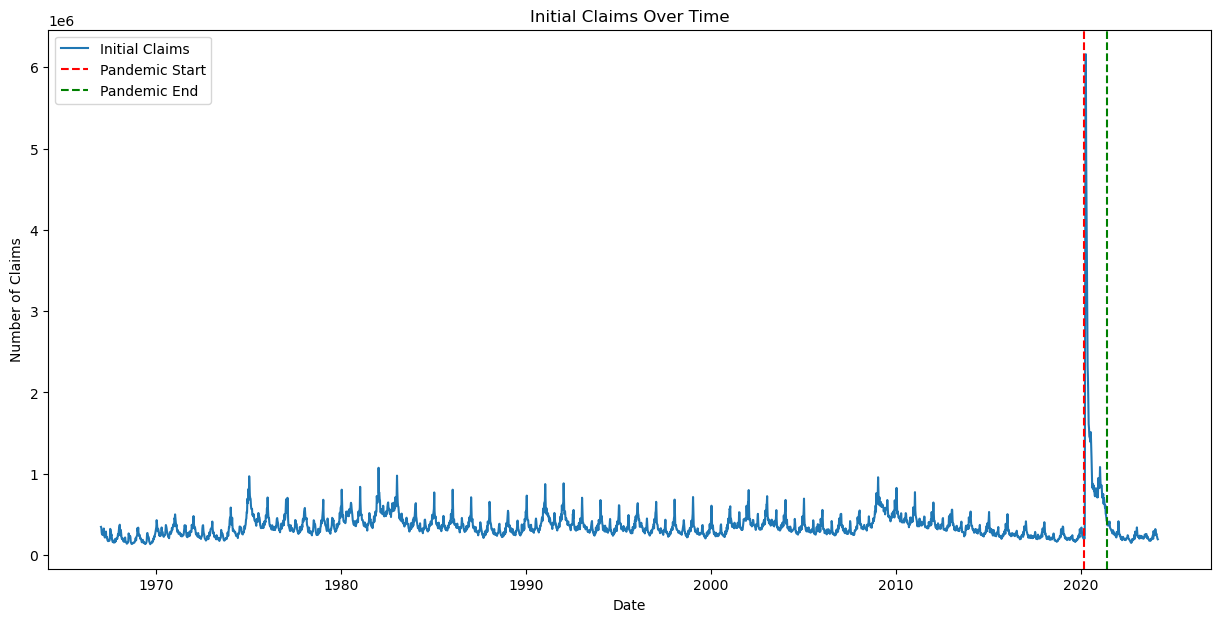

In [6]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 7))
plt.plot(icnsa_df['time'], icnsa_df['I_value'], label='Initial Claims')

plt.axvline(x=pd.Timestamp('2020-03-01'), color='r', linestyle='--', label='Pandemic Start')
plt.axvline(x=pd.Timestamp('2021-06-01'), color='g', linestyle='--', label='Pandemic End')

plt.title('Initial Claims Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Claims')
plt.legend()
plt.show()


According to the documentation, In python, the `KalmanSmoother` is not explicitly mentioned. Instead, we are using the SARIMAX model from the `statsmodels` library for imputation. The Kalman Filter is inherently part of the state-space models like SARIMAX to handle estimation and imputation. When fitting a SARIMAX model to impute missing values, the Kalman Filter is utilized internally by the library to perform these tasks. The Smoother would be involved in the background during the `.fit()` method execution and when calling `.predict()` or similar methods that infer missing data points. It operates behind the scenes as part of the state-space model's implementation in `statsmodels`, providing estimates for missing or unobserved values based on the observed data

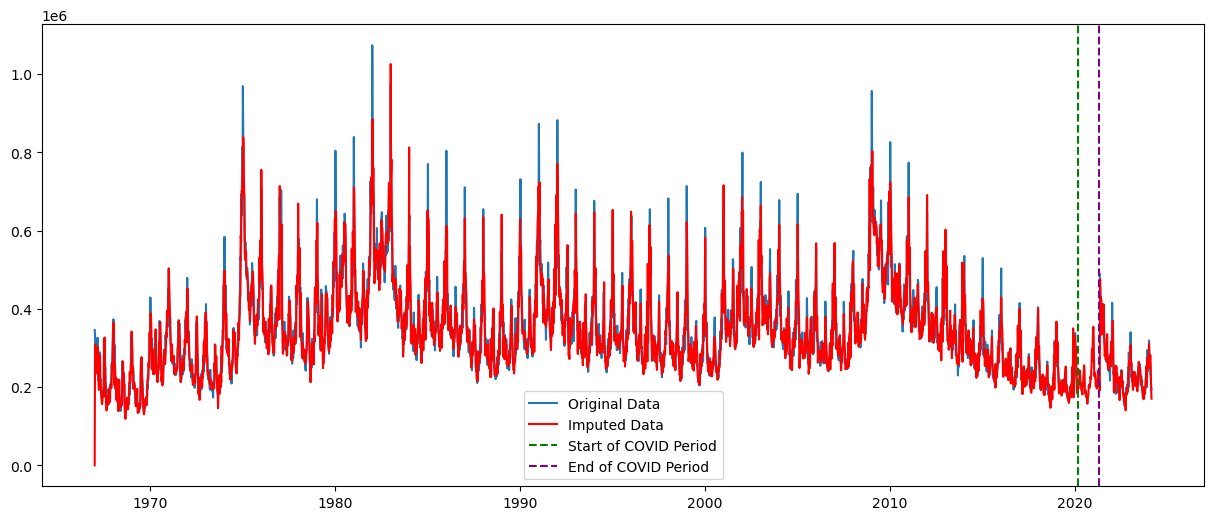

In [31]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.structural import UnobservedComponents
import matplotlib.pyplot as plt


start_index = icnsa_df[icnsa_df['time'] == '2020-03-14'].index[0]
end_index = icnsa_df[icnsa_df['time'] == '2021-05-01'].index[0]

icnsa_df.loc[start_index:end_index, 'I_value'] = np.nan

model = UnobservedComponents(icnsa_df['I_value'], 
                             level='llevel',  
                             seasonal=52,     
                             freq_seasonal=[{'period': 52, 'harmonics': 4}], autoregressive=1,
                            robust=True)  

results = model.fit()

# Impute the missing values using the predict method , it uses the Kalman Smoother internally for the imputation
icnsa_df['imputed_I_value'] = results.predict()

# Plot the series with imputed values
plt.figure(figsize=(15, 6))
plt.plot(icnsa_df['time'], icnsa_df['I_value'], label='Original Data')
plt.plot(icnsa_df['time'], icnsa_df['imputed_I_value'], label='Imputed Data', color='red')
plt.axvline(x=icnsa_df['time'].iloc[start_index], color='green', linestyle='--', label='Start of COVID Period')
plt.axvline(x=icnsa_df['time'].iloc[end_index], color='purple', linestyle='--', label='End of COVID Period')
plt.legend()
plt.show()


1. **State-Space Model**:
   - The state-space imputation appears closely follow the original data's pattern before the covid period thereby not capturing the sudden drop and fluctuations during the covid period, which might be reasonable if we want to estimate what the series would have looked like without the pandemic.

2. **Cubic Splines**:
   - The cubic splines imputations are sensitive to local changes and tends to create a smooth curve that may not always align with the actual data patterns.
   - It seems to capture the trends from the pre-COVID data in a way that is inconsitent with the historical data, leading to an unrealistic upward spike.
   - This approach is purely mathematical and lacks the statistical grounding that the state-space method provides.

In conclusion, the state-space model may be more appropriate if we are looking for an imputation that maintains the pre-COVID statistical properties of the time series. However, it fails to reflect the real-world impact of COVID. The cubic splines imputation may look artificially smooth and is less realistic in terms of capturing possible time series patterns.


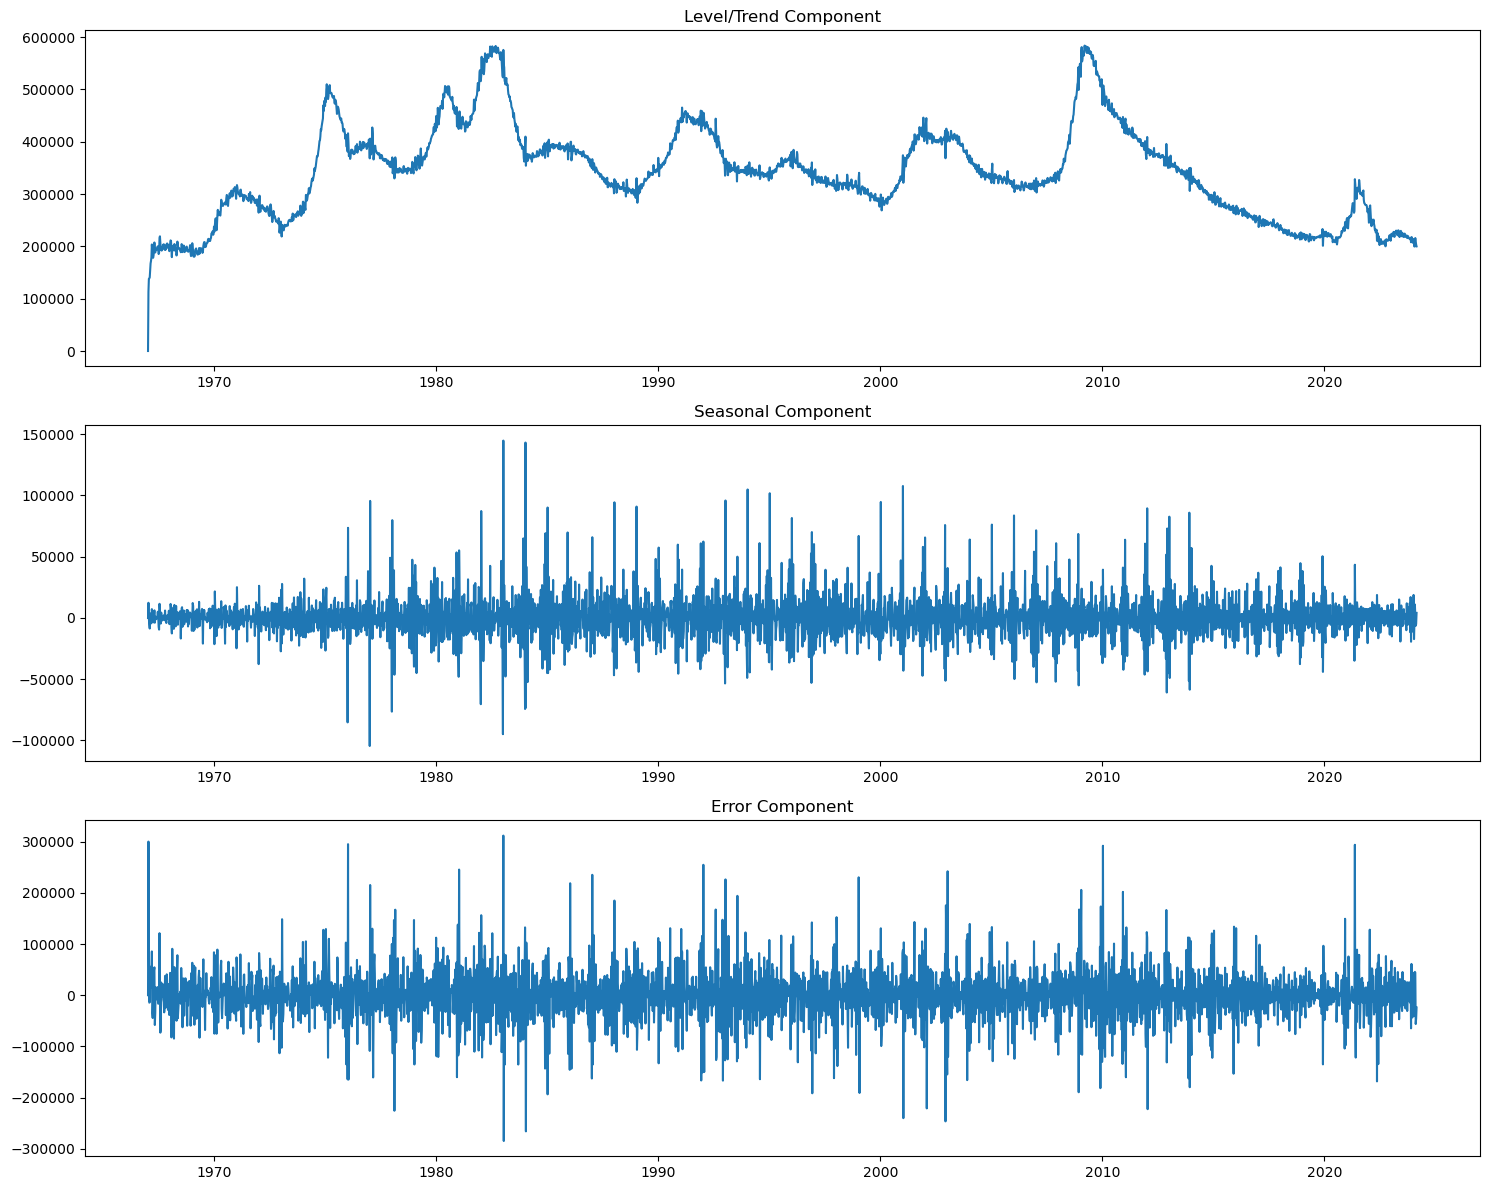

In [20]:

model_with_imputed = UnobservedComponents(
    icnsa_df['imputed_I_value'], 
    level='llevel',
    seasonal=52,     
    freq_seasonal=[{'period': 52, 'harmonics': 4}], 
    autoregressive=1, robust=True      
)

results_with_imputed = model_with_imputed.fit()

# forecast = results_with_imputed.get_forecast(steps=1) 
# conf_int = forecast.conf_int() 

# Plotting the components of the model
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 12))

# Level/Trend
axes[0].plot(icnsa_df['time'], results_with_imputed.level.smoothed, label='Level/Trend')
axes[0].set_title('Level/Trend Component')

# Seasonal
axes[1].plot(icnsa_df['time'], results_with_imputed.seasonal.smoothed, label='Seasonal')
axes[1].set_title('Seasonal Component')

# # Autoregressive
# axes[2].plot(icnsa_df['time'], results_with_imputed.autoregressive.smoothed, label='Autoregressive')
# axes[2].set_title('Autoregressive Component')

# Error
axes[2].plot(icnsa_df['time'], results_with_imputed.resid, label='Error')
axes[2].set_title('Error Component')

# Show the plot
plt.tight_layout()
plt.show()


Reason for using `UnobservedComponents` model:

1. The model decomposes the time series into several components, each representing an underlying process like the trend or seasonal pattern.

2. The level or trend component can be specified in various ways (e.g., local level or local linear trend), and the seasonal component can be modeled to capture complex patterns.

3. It has the capability to model the autoregressive nature of time series, which is evident from the lagged relationship of the data.

4. With the robust parameter set to `True`, it can provide estimates that are less sensitive to outliers, which could be beneficial in time series with anomalies or non-normal errors.

The 'UnobservedComponents' model specified with "level='llevel'", "seasonal=52", and "autoregressive=1" indicates that the ICNSA time series are modelled with:
- A local level model to capture the trend,
- A seasonal component with an annual frequency (data is weekly, hence 52 weeks),
- An autoregressive component of order 1, which captures the dependency of the series on its immediate past value (considering from acf and pacf plots)

The model is fit to the `imputed_I_value` series from the ICNSA data, which would have filled in the missing values due to COVID with estimates based on the observed patterns in the data.


1. **Level/Trend Component**:
   - The level/trend component shows a clear long-term pattern in the data, with peaks and troughs corresponding to potential economic cycles in the ICNSA series.
   - The change in the variance of the trend over time suggests that the volatility of the series is not constant. This could mean that different periods have different levels of uncertainty, which may need to be accounted for in the model.


2. **Seasonal Component:**
   - The seasonal component exhibits regular fluctuations, which indicates a strong seasonal pattern within the ICNSA series. 
   - The magnitude of seasonal effects appears to be relatively stable over time, which suggests that the seasonal pattern does not change much year over year.


3. **Error Component:**
   - The error component seems to have some large spikes, suggesting that there are still some unexplained variations in the data. This could be due to outliers, structural breaks (like the COVID-19 pandemic), or other factors not accounted for by the model.



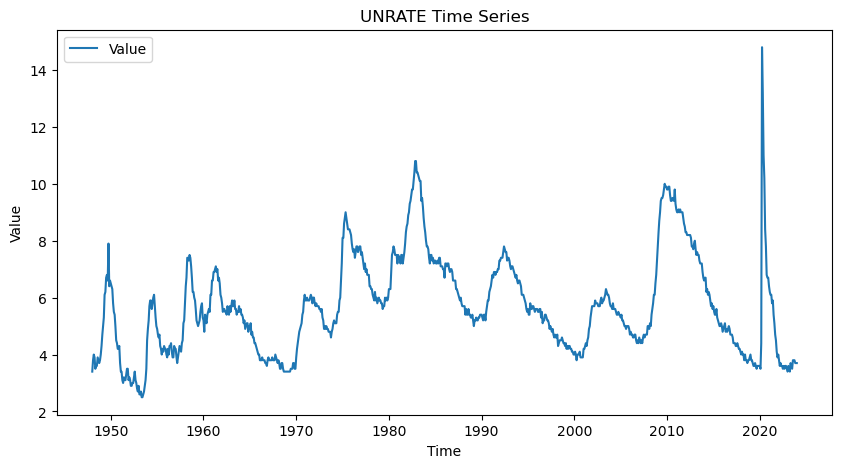

In [42]:
covariate_series_id = "UNRATE"
unrate_data = fred.get_series(covariate_series_id)

unrate_df = unrate_data.to_frame().reset_index()
unrate_df.columns = ['time', 'U_value']


# # Plotting the time series using Matplotlib
plt.figure(figsize=(10, 5)) 
plt.plot(unrate_df['time'], unrate_df['U_value'], label='Value') 
plt.title(f"{covariate_series_id} Time Series")  
plt.xlabel('Time')
plt.ylabel('Value')  
plt.legend()  
plt.show()  


**Reason for the unemployment rate (UNRATE) to be a good covariate for the ICNSA series:**
The ICNSA is directly related to the labor market, just like the unemployment rate. Both measure aspects of employment conditions, and changes in one are likely to be reflected in the other.During recessions, the unemployment rate typically rises, and initial claims increase. During expansions, the opposite occurs.Although the unemployment rate is reported monthly, it is still relatively high frequency and timely, which makes it a good candidate for inclusion in models analyzing other high-frequency economic data.

In [45]:
monthly_icnsa_df = icnsa_df.resample('M', on='time').mean()

# Reset the index to turn the time index into a column
monthly_icnsa_df = monthly_icnsa_df.reset_index()
monthly_icnsa_df['time'] = monthly_icnsa_df['time'] + pd.offsets.MonthEnd(0)
unrate_df['time'] = unrate_df['time'] + pd.offsets.MonthEnd(0)

#merging the DataFrames on the 'time' column
merged_df = pd.merge(monthly_icnsa_df, unrate_df, on='time', how='inner')

,time,I_value,imputed_I_value
0,1967-01-31,302250.00,220945.240558
1,1967-02-28,261250.00,248812.320364
2,1967-03-31,251500.00,246359.161644
3,1967-04-30,239400.00,227050.253738
4,1967-05-31,189000.00,183103.868543
...,...,...,...
681,2023-10-31,193860.50,192655.043070
682,2023-11-30,218082.00,221909.543694
683,2023-12-31,265798.80,267030.151124
684,2024-01-31,281025.50,272040.745580


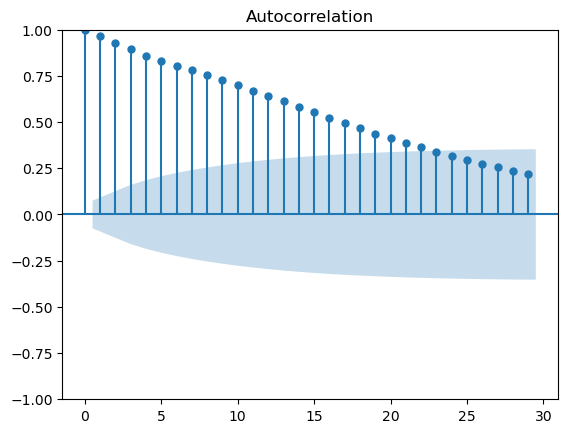

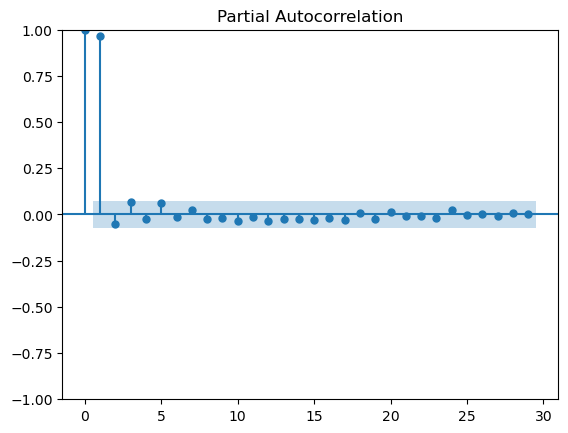

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(merged_df['U_value'].dropna())
plot_pacf(merged_df['U_value'].dropna())
plt.show()



1. **Autocorrelation Function (ACF) Plot Observations:**
   - The ACF plot shows significant autocorrelation at numerous lag intervals, with a slow decay as the lag increases. This suggests that the data points are positively correlated with their past values, and this correlation persists across multiple time lags.
   - The gradual decline in autocorrelation values indicates a trend or long-term cyclical patterns in the data.

2. **Partial Autocorrelation Function (PACF) Plot Observations:**
   - The PACF plot exhibits a significant spike at lag 1, which suggests a strong correlation between each observation and its immediate predecessor.
   - Beyond lag 1, the PACF values fall within the confidence interval, suggesting that additional autocorrelations do not contribute additional explanatory power.

To summarize, The UNRATE series is influenced by its own past values, primarily at the first lag. While modeling such data, an AR(1) model could be a starting point as it involves a single autoregressive term.However, when the ACF does not cut off quickly and instead shows a gradual decline, it might also be indicative of a non-stationary series. 

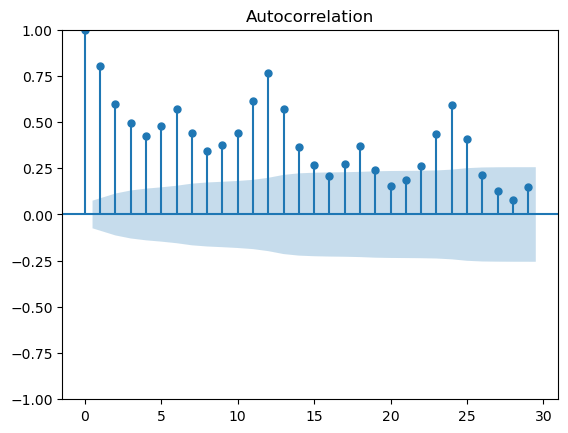

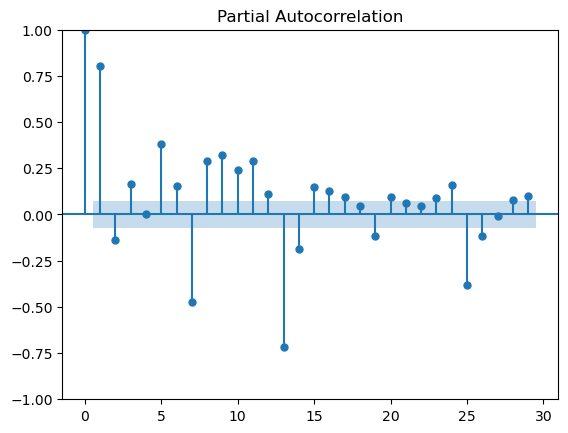

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(merged_df['imputed_I_value'].dropna())
plot_pacf(merged_df['imputed_I_value'].dropna())
plt.show()



1. **ACF Plot Observations**:
   - The ACF plot shows significant positive autocorrelations for many lags, which gradually decline as the lags increase. This could that the past values have influence on future values.
   - It also indicates the presence of trend or long-term cyclical behavior in the data. This pattern maily suggests non-stationary of data.

2. **PACF Plot Observations**:
   - The PACF plot shows a significant spike at the first lag, which then falls off quickly, indicating that the value at lag one provides significant information about the current value. 
   - There are some spikes at higher lags, but these are within the bounds of statistical significance, which suggests they may not be reliable indicators of true autocorrelation.

Considering these observations, for the ICNSA series, we need to perform differencing to remove the non-stationarity suggested by the slow decay in the ACF plot. The significant lag-1 autocorrelation in the PACF plot suggests that an AR(1) model could be a good starting point.

However, as the ACF shows a long tail, there might be some seasonality that needs to be taken into consideration by including seasonal ARIMA components.

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(merged_df['imputed_I_value'], 
                        exog=merged_df['U_value'], 
                        order=(1, 1, 0),
                        seasonal_order=(1, 1, 1, 52),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarimax_results = sarimax_model.fit()



In [61]:
forecast = sarimax_results.get_forecast(steps=1, exog=next_period_exog)
forecast_value = forecast.predicted_mean
confidence_intervals = forecast.conf_int()


In [63]:
forecast_value

685    234824.301685
dtype: float64

In [59]:
from statsmodels.tsa.arima.model import ARIMA

# Forecast the next period's UNRATE value
unrate_model = ARIMA(merged_df['U_value'], order=(1, 1, 0))
unrate_results = unrate_model.fit()
next_period_exog = unrate_results.forecast(steps=1)


In [60]:
next_period_exog

685    3.7
dtype: float64